This notebook analyzes scaling laws when learning on top of frozen embeddings.

It is meant to serve as the more interactive version of
`src.pretrain.probe_embeddings`.

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import sys

import cuml.neighbors.kneighbors_classifier
import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src.pretrain import gen_embeddings, probe_embeddings
from src.pretrain.datasets.embedding import EmbeddingDataset
from src.pretrain.datasets.vision import imagenette, svhn
from src.pretrain.models.vision import laion_clip, openai_clip, msft_beit

### Load data

In [3]:
dataset_cfg = imagenette.Imagenette()
embedder_cfg = msft_beit.MsftBeitConfig(id="hf/microsoft/beit-base-patch16-384")

embedding_cfg = gen_embeddings.Config(
    dataset_cfg=dataset_cfg,
    embedder_cfg=embedder_cfg,
)
probe_cfg = probe_embeddings.Config(
    embedder_cfg=embedder_cfg,
    dataset_cfg=dataset_cfg,
)

DS = EmbeddingDataset.load_from_file(embedding_cfg.full_save_path).astype(
    np.float32
)
DS.xs_train.shape, DS.xs_test.shape, DS.xs_test.dtype


((9469, 768), (3925, 768), dtype('float32'))

### Dataset info

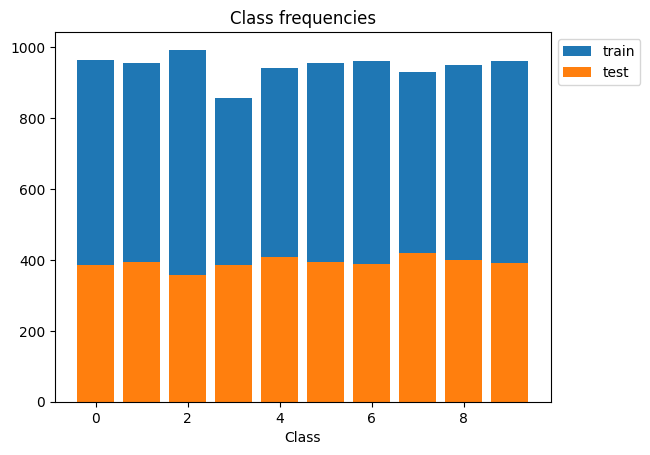

In [4]:
probe_embeddings.plot_class_frequencies(DS);

### Visualize embeddings with UMAP

In [5]:
probe_embeddings.plot_umap(DS, cfg=probe_cfg).show()

### Visualize suspicious dataset examples

In [6]:
# Compute test examples that are classified wrong according to 10-NN.
clf = cuml.neighbors.kneighbors_classifier.KNeighborsClassifier(
    n_neighbors=3,
    weights="uniform",
    metric="euclidean",
)
clf.fit(DS.xs_train, DS.ys_train)
preds = clf.predict(DS.xs_test)

err_idxs = np.where(preds != DS.ys_test)[0]
err_idxs

array([  82,  956, 2095])

Found cached dataset imagenette (/run/user/61805/huggingface/datasets/frgfm___imagenette/320px/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f)


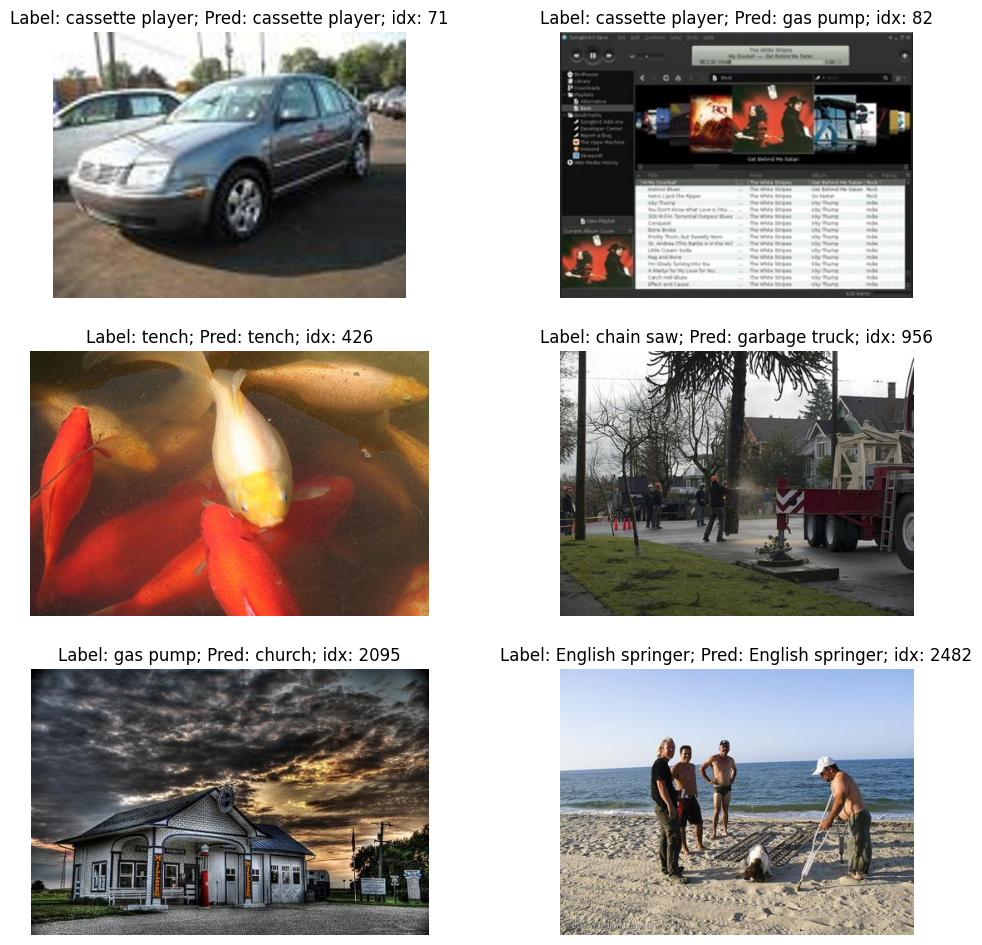

In [7]:
ds_orig_test = dataset_cfg.get_test_ds()
sus_idxs = [71, 82, 426, 956, 2095, 2482]

n_rows = 5
n_cols = 2
plt.figure(figsize=(n_cols * 6, n_rows * 4))
for i, idx in enumerate(sus_idxs):

    idx = int(idx)
    img = ds_orig_test[idx]["image"]

    label_num = ds_orig_test[idx]["label"]
    label_str = dataset_cfg.class_names[label_num]

    pred_num = preds[idx]
    pred_str = dataset_cfg.class_names[pred_num]

    # Plot image without axes
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Label: {label_str}; Pred: {pred_str}; idx: {idx}")

### Visualize embeddings with PCA

In [8]:
probe_embeddings.plot_pca(DS, cfg=probe_cfg).show()

/run/user/61805/conda-envs/scaling-v2.1/lib/python3.9/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



### Measure scaling laws

In [9]:
df = probe_embeddings.get_scaling_results(ds=DS, cfg=probe_cfg)

  0%|          | 0/6 [00:00<?, ?it/s]

/home/gridsan/twang/code/scaling/src/pretrain/probes/linear_probe.py:18: RuntimeWarning:

divide by zero encountered in log

/home/gridsan/twang/code/scaling/src/pretrain/probes/linear_probe.py:17: RuntimeWarning:

divide by zero encountered in log

/home/gridsan/twang/code/scaling/src/pretrain/probes/linear_probe.py:21: RuntimeWarning:

invalid value encountered in multiply



[W] [16:10:43.538465] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [16:10:44.866376] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [16:10:45.462716] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [16:10:48.669991] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [16:10:48.807144] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [16:10:48.995491] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [16:10:51.558157] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [16:10:52.477653] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [16:10:53.397036] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [16:10:53.819448] L-BFGS stopped, because the line search fa

### Plot scaling laws

In [10]:
tot_classes = DS.n_classes
for n_classes in probe_cfg.n_classes:
    for i in range(probe_cfg.mx_cont_rngs):
        for per_class in [False, True]:
            cls_start = i * n_classes
            cls_end = cls_start + n_classes
            if cls_end > tot_classes:
                break

            fig = probe_embeddings.plot_scaling_results(
                df=df,
                n_classes=n_classes,
                cls_start=cls_start,
                cls_end=cls_end,
                per_class=per_class,
            )
            fig.show()

            break
        break
    break